# Învățare Automată
# Clasificare folosind Support Vector Machines
### Autori:
* Alexandru Sorici - 2017
* George Muraru - 2020

## 1. Scopul laboratorului

Scopul laboratorului îl reprezintă înțelegerea și implementarea unui clasificator SVM, ce poate folosi mai multe tipuri de kernel-uri. În cadrul laboratorului se vor face operații de clasificare pe seturi de date sintetice, ce pun în evidență utilitatea kernel-urilor atunci când spațiul de intrare nu este liniar separabil. Rezolvarea cerințelor se va face pas cu pas urmând indicațiile și explicațiile primite.

## 2. Descriere teoretică

SVM-urile sunt clasificatoare decizionale (i.e. nu au ca rezultat o probabilitate ca un input să facă parte dintr-o clasă dată).

O proprietate importantă a SVM-urilor este că determinarea parametrilor
modelului se face prin rezolvarea unei probleme de optimizare convexa, ceea
ce înseamnă că orice soluție locală este și un optim global.

SVM-ul este un clasificator binar, iar problema pe care încearcă să o rezolve este găsirea unui hiperplan de separație care maximizează marginea între hiperplan și cele mai apropiate exemple pozitive și negative.

![SVM](https://raw.githubusercontent.com/cs-pub-ro/ML/master/lab/lab4/img/hyperplane-margin.jpg)


## 3. Workspace setup

### Dependențe


In [1]:
!pip install numpy
!pip install sklearn
!pip install cvxopt


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\Andrei\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement sklearn (from versions: none)
ERROR: No matching distribution found for sklearn

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\Andrei\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\Andrei\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### Câteva bibioteci de care vom avea nevoie

In [2]:
import numpy as np
import numpy.linalg as la
import cvxopt.solvers

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import make_moons, make_circles, make_classification

import logging 

### Parametrii necesari rulării

In [3]:
MIN_SUPPORT_VECTOR_MULTIPLIER = 1e-5
H = .1  # step size in the mesh

### Clasa ajutătoare

In [4]:
class SVMPredictor(object):
    def __init__(self,
                 kernel,
                 bias,
                 weights,
                 support_vectors,
                 support_vector_labels):
        self._kernel = kernel
        self._bias = bias
        self._weights = weights
        self._support_vectors = support_vectors
        self._support_vector_labels = support_vector_labels
        assert len(support_vectors) == len(support_vector_labels)
        assert len(weights) == len(support_vector_labels)
        logging.info("Bias: %s", self._bias)
        logging.info("Weights: %s", self._weights)
        logging.info("Support vectors: %s", self._support_vectors)
        logging.info("Support vector labels: %s", self._support_vector_labels)
    
    def num_misclassified(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y).ravel().astype(float)

        preds = np.array([self.predict(x) for x in X], dtype=float)

        return int(np.sum(preds != y))

    def predict(self, x):
        """
        Calculeaza predictia facuta de un SVM, dandu-se inputul x.
        Formula de calcul este:
            \sum_m [z_m * y_m * kernel(x_m, x)] + bias

            unde m itereaza peste multimea vectorilor de suport
        """
        result = self._bias
        for z_i, x_i, y_i in zip(self._weights,
                                 self._support_vectors,
                                 self._support_vector_labels):
            result += z_i * y_i * self._kernel(x_i, x)
        return np.sign(result).item()

    def score(self, X_test, y_test):
        nr_samples, nr_dim = X_test.shape

        predictions = np.array(list(map(self.predict, X_test)))
        matches = np.multiply(predictions, y_test)

        score = sum(matches[matches == 1], 0) * 1.0 / nr_samples
        return score

## Cerințe

1. Completați codul de mai jos pentru a întoarce 2 funcții:
* un kernel liniar
$$
k(x,y) = \langle x, y \rangle
$$
* un kernel bazat pe Radial Basis Function
$$
k(x,y) = exp(-\gamma||x - y||^2)
$$



In [5]:
def linear():
    """
    Intoarce o functie anonima ce calculeaza produsul scalar a doi vectori x si y
    :return:
    """
    return lambda x, y: float(np.dot(np.ravel(x), np.ravel(y)))

def radial_basis(gamma=10):
    """
    Intoarce o functie anonima ce implementeaza forma de Radial Basis Function, avand parametrul \gamma
    :param gamma: parametrul de ponderare a normei diferentei vectorilor x si y
    :return:
    """
    gamma = float(gamma)
    def _k(x, y):
        diff = np.ravel(x) - np.ravel(y)
        return float(np.exp(-gamma * np.dot(diff, diff)))
    return _k

2. Completați metoda **_gram_matrix** de mai jos astfel încât aceasta să întoarca matricea Gram (K), dandu-se setul de date X.

In [6]:
class SVMTrainer(object):
    def __init__(self, kernel, c):
        self._kernel = kernel
        self._c = c
    
    def fit(self, X, y):
        """
        Dandu-se setul de antrenare X si label-urile y, intoarce un SVM antrenat.
        :param X: setul de antrenare avand dimensiunea (num_training_points, num_features)
        :param y: eticheta fiecarui input din setup de antrenare, avand dimensiunea (num_training_points, 1)
        :return: Predictorul SVM antrenat.
        """
        ## Pas 1 - calculeaza multiplicatorii Lagrange, rezolvand problema duala
        lagrange_multipliers = self._compute_multipliers(X, y)

        ## Pas 2 - intoarce predictorul SVM pe baza multiplicatorilor Lagrange
        return self._construct_predictor(X, y, lagrange_multipliers)

    def _gram_matrix(self, X):
        """
        Precalculeaza matricea Gram, folosind kernel-ul dat in constructor, in vederea rezolvarii problemei duale.
        :param X: setul de date de antrenare avand dimesiunea (num_samples, num_features)
        :return: Matricea Gram precalculata
        """
        n_samples, n_features = X.shape
        K = np.zeros((n_samples, n_samples))

        # TODO: populati matricea Gram conform kernel-ului selectat
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self._kernel(X[i], X[j])

        return K

    def _construct_predictor(self, X, y, lagrange_multipliers):
        support_vector_indices = \
            lagrange_multipliers > MIN_SUPPORT_VECTOR_MULTIPLIER

        support_multipliers = lagrange_multipliers[support_vector_indices]
        support_vectors = X[support_vector_indices]
        support_vector_labels = y[support_vector_indices]

        # bias = y_k - \sum z_i y_i  K(x_k, x_i)
        ## Desi bias-ul poate fi calculat pe baza unei singure valori din setul vectorilor de suport,
        # pentru o forma stabila numeric, folosim o media peste toti vectorii suport
        bias = np.mean(
            [y_k - SVMPredictor(
                kernel=self._kernel,
                bias=0.0,
                weights=support_multipliers,
                support_vectors=support_vectors,
                support_vector_labels=support_vector_labels).predict(x_k)
             for (y_k, x_k) in zip(support_vector_labels, support_vectors)])

        return SVMPredictor(
            kernel=self._kernel,
            bias=bias,
            weights=support_multipliers,
            support_vectors=support_vectors,
            support_vector_labels=support_vector_labels)

    def _compute_multipliers(self, X, y):
        """
        Rezolva problema de optimizare duala, calculand valoarea multiplicatorilor Lagrange
        :param X: setul de date de antrenare avand dimensiunea (num_samples, num_features)
        :param y: setul de etichete pentru datele de antrenare avand dimensiunea (num_samples, )
        :return: lista multiplicatorilor Lagrange
        """
        n_samples, n_features = X.shape

        K = self._gram_matrix(X)
        """
        Metoda din cvxopt ce rezolva o problema de optimizare patratica are urmatoarea formulare
        min 1/2 x^T P x + q^T x
        a.i.
        Gx < h
        Ax = b
        
        unde x este vectorul de valori x_i, de dimensiune (n_samples, 1) a carui valoare se cauta
        """

        """
        Problema duala pentru SVM cere:
        min 1/2 a^T Q a - 1^T a
        a.i.
        0 <= a_i, orice i
       -a_i <= 0
        a_i <= C, orice i
        y^T a = 0

        unde Q = (y * y^T) . K (i.e. inmultire matriceala intre y si y^T si apoi inmultire element-cu-element cu matricea K)

        Aici vectorul pe care il cautam este `a' (cel al multiplicatorilor Lagrange) de dimensiune (n_samples, 1).
        """

        """
        Cerinta este de a gasi maparea corecta intre forma duala pentru SVM si cea utilizata de cvxopt, i.e. ce valori trebuie sa ia
        matricile P, G si A si vectorii q, h si b, astfel incat ei sa reprezinte expresiile din forma duala SVM.
        
        Vectorul `a' tine loc de `x' in forma ecuatiilor pentru cvxopt.
        """

        # TODO calculeaza valoarea matricii P = (y * y^T) . K 
        # P = cvxopt.matrix(...)
        P = cvxopt.matrix(np.outer(y, y) * K)

        # TODO calculeaza valoarea vectorului q
        # q = cvxopt.matrix(...)
        q = cvxopt.matrix(-np.ones(n_samples))

        # setam G si h in doi pasi a.i sa cuprinda cele doua inegalitati, 0 <= a_i si a_i <= C
        # TODO seteaza G_std si h_std pentru a rezolva -a <= 0
        # G_std = cvxopt.matrix(...)
        # h_std = cvxopt.matrix(...)
        G_std = cvxopt.matrix(-np.eye(n_samples))
        h_std = cvxopt.matrix(np.zeros(n_samples))

        # TODO seteaza G_slack si h_slack pentru a rezolva a <= C
        # G_slack = cvxopt.matrix(...)
        # h_slack = cvxopt.matrix(...)
        G_slack = cvxopt.matrix(np.eye(n_samples))
        h_slack = cvxopt.matrix(np.ones(n_samples) * self._c)

        # TODO obtine G si h prin suprapunere a variabilelor anterioare (vezi functia numpy.vstack)
        # G = cvxopt.matrix(...)
        # h = cvxopt.matrix(...)
        G = cvxopt.matrix(np.vstack((G_std, G_slack)))
        h = cvxopt.matrix(np.vstack((h_std, h_slack)))

        # TODO seteaza A si b a.i. sa acopere relatia y^T a = \sum y_i a_i
        # A = cvxopt.matrix(..., tc = 'd')
        # b = cvxopt.matrix(...)
        A = cvxopt.matrix(y, (1, n_samples), tc='d')
        b = cvxopt.matrix(0.0)

        cvxopt.solvers.options['show_progress'] = False
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)        # decomentati linia cand ati implementat matricile de mai sus

        # intoarcem multiplicatorii Lagrange sub forma liniarizata - vezi functia np.ravel
        return np.ravel(solution['x'])                        # decomentati linia cand ati implementat matricile de mai sus

3. Completați în funcția **compute_multipliers** (în clasa de mai sus), astfel încât aceasta să întoarcă lista multiplicatorilor Lagrange ce rezolvă formularea
duală a problemei de optimizare SVM descrisă în pdf.

   Biblioteca *cvxopt* dispune de o metodă de rezolvare a problemelor de optimizare pătratică ce au următoarea formă:
$$
\min\frac{1}{2}x^TPx + q^Tx\\
a.î. \\ 
Gx \prec h \\
Ax = b
$$

    Problema duală pentru SVM poate fi rescrisă sub forma matricială astfel:
$$
\min\frac{1}{2}a^TQa - 1^Ta\\
a.î.\\
0 \leq a_i, i = 1,...,n\\
a_i \leq C, i = 1,...,n\\
y^Ta = 0
$$

    unde:
    * $Q = (yy^T)\cdot K$ (înmulțire matriceală între $y$ și $y^T$ și apoi înmulțire element-cu-element cu matricea K)

    HINT: Folosiți funcțiile *cvxopt.matrix, numpy.outer, numpy.ones, numpy.zeros, numpy.diag, numpy.vstack*. Folosiți peste tot unde creați matrici sau vectori, funcția *cvxopt.matrix* ca wrapper peste expresii de *numpy*. Wrapper-ul este necesar apelării ulterioare a solver-ului din biblioteca *cvxopt*.

4. Analizați modul în care se modifică scorul de clasificare și forma curbei de
separație atunci când variați parametrul C in intervalul $[10^{-3},10^3]$ prin puteri ale lui 10.

   Implementați o funcție **num_misclassified** în clasa **SVMTrainer** care să întoarcă numărul de vectori de intrare clasificați incorect. Luați drept punct de plecare codul din funcția **score** din clasa **SVMPredictor**. Observati influența parametrului C asupra rezultatului întors de funcția **num_misclassified**.

### Testing

<module 'matplotlib.pyplot' from 'C:\\Users\\Andrei\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\matplotlib\\pyplot.py'>

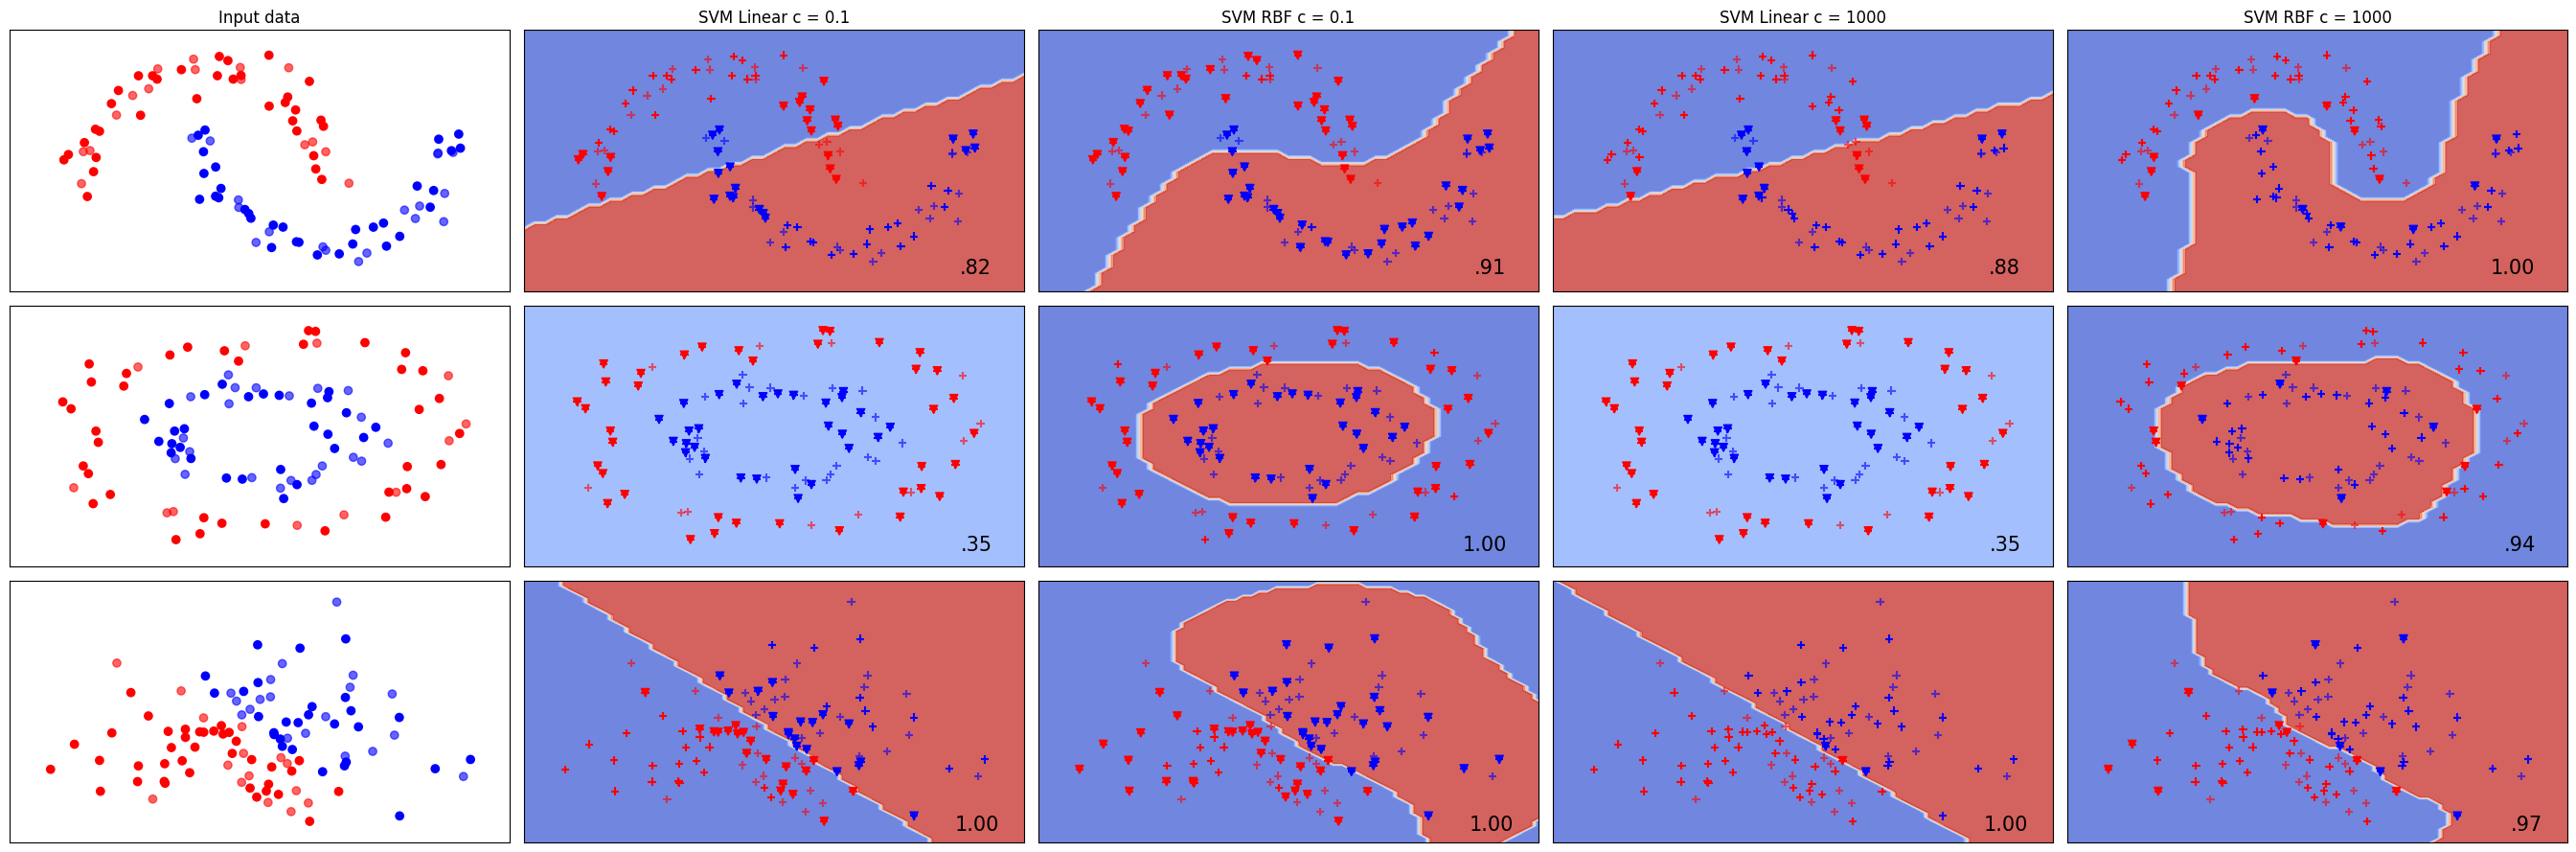

In [13]:
#@title
num_samples = 100
num_features = 2
# X = np.matrix(np.random.normal(size=num_samples * num_features)
                # .reshape(num_samples, num_features))
X = np.random.normal(size=num_samples * num_features).reshape(num_samples, num_features)
y = np.ravel(2 * (X.sum(axis=1) > 0) - 1.0)
linearly_separable = (X, y)

names = ["SVM Linear c = 0.1", "SVM RBF c = 0.1", "SVM Linear c = 1000", "SVM RBF c = 1000"]
datasets = [make_moons(noise=0.1, random_state=0),
            make_circles(noise=0.1, factor=0.5, random_state=1),
            linearly_separable
            ]

classifiers = [
    SVMTrainer(kernel=linear(), c = 0.1),
    SVMTrainer(kernel=radial_basis(gamma=1), c = 0.1),
    SVMTrainer(kernel=linear(), c=1000),
    SVMTrainer(kernel=radial_basis(gamma=1), c=1000),
]

figure = plt.figure(figsize=(27, 9))
i = 1
for ds_cnt, ds in enumerate(datasets):
    X, y = ds
    ## modify labels to correspond to SVM categories {-1, 1}
    y[y == 0] = -1

    X = StandardScaler().fit_transform(X)

    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.34, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, H),
                        np.arange(y_min, y_max, H))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        predictor = clf.fit(X_train, y_train)
        score = predictor.score(X_test, y_test)

        mesh = np.c_[xx.ravel(), yy.ravel()]

        Z = np.array(list(map(predictor.predict, mesh)))
        Z = Z.reshape(xx.shape)

        ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='+', cmap=cm_bright)
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='+', cmap=cm_bright, alpha=0.6)

        #print(name, end=": ")
        #print(predictor.num_misclassified(X_test, y_test))
        # Plot the support vectors
        ax.scatter(predictor._support_vectors[:, 0], predictor._support_vectors[:, 1], marker='v',
                c=predictor._support_vector_labels, cmap=cm_bright)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt

In [14]:
C_values = [10**k for k in range(-3, 4)]
kernel = linear()

print("C\ttrain_acc\ttest_acc\ttrain_err\ttest_err")
for C in C_values:
    trainer = SVMTrainer(kernel=kernel, c=C)
    predictor = trainer.fit(X_train, y_train)

    train_score = predictor.score(X_train, y_train)
    test_score  = predictor.score(X_test, y_test)

    train_err = predictor.num_misclassified(X_train, y_train)
    test_err  = predictor.num_misclassified(X_test, y_test)

    print(f"{C:g}\t{train_score:.3f}\t\t{test_score:.3f}\t\t{train_err}\t\t{test_err}")

C	train_acc	test_acc	train_err	test_err
0.001	0.727		0.676		18		11
0.01	1.000		1.000		0		0
0.1	1.000		1.000		0		0
1	0.985		1.000		1		0
10	0.985		1.000		1		0
100	1.000		1.000		0		0
1000	0.985		1.000		1		0
